Initialise code for google colab

Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_addons as tfa
print(tfa.__version__)

2.9.2


ModuleNotFoundError: ignored

In [3]:
!pip install tensorflow==2.11
!pip install tensorflow-addons==0.19

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 111.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 44.8 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorboard
    Found existing 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.5 MB/s eta 0:00:00


Create data base files under google colab environment

In [1]:
!unzip -q '/content/drive/MyDrive/data_equalize.zip' -d '/content/'

For Luc because my archive made on mac create a __MACOSX folder

In [ ]:
%rm -rf /content/__MACOSX

Define working directory to our jupyter repertory:
* because path to the different repertories (./data, ./output...) are define relatevly to jupyter one
* let import _mypath which add ./lib to python path in order to import our own define libraries


In [1]:
%cd /content/drive/MyDrive/covid-19-xRay/jupyter


[Errno 2] No such file or directory: '/content/drive/MyDrive/covid-19-xRay/jupyter'
/Users/luc/git/covid-19-xRay/jupyter


In [3]:
# for google colab use
from google.colab.patches import cv2_imshow
db_work_dir = '/content'


In [1]:
# for local use
db_work_dir = '..'

In [2]:
import _mypath
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2

%load_ext autoreload
%autoreload 1



2023-01-24 11:10:20.764337: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
%aimport database.path_origin_data
%aimport database.dataset

from database.path_origin_data import build_data_paths 
from database.path_origin_data import lung_name, infection_name
from database.path_origin_data import train_name, test_name, valid_name
from database.path_origin_data import normal_name, covid_name, no_covid_name
from database.path_origin_data import images_name, lung_mask_name, infection_mask_name

from database.dataset import build_dataset

%aimport run_exp.test
%aimport run_exp.classif_autoencoder
%aimport run_exp.standard

from run_exp.test import compile_test_model
from run_exp.classif_autoencoder import run_experiment as run_experiment_autoencoder
from run_exp.standard import run_experiment as run_experiment_pure_cnn



Build paths and variables for reading data base hierarchy

In [7]:
db_name = 'data_equalize'
db_path = os.path.join(db_work_dir, db_name)

output_path = os.path.join('..', 'output')
if not os.path.exists(output_path):
    os.makedirs(output_path, exist_ok=True)

Structure to manage paths in data base

In [8]:
data_paths = build_data_paths()
idx = pd.IndexSlice

Create tf Dataset

In [9]:

paths = data_paths['path']

ds_train = build_dataset(db_path, paths, db=[lung_name], ds=[train_name])
ds_test = build_dataset(db_path, paths, db=[lung_name], ds=[test_name])
ds_valid = build_dataset(db_path, paths, db=[lung_name], ds=[valid_name])
ds_train


Found 6849 files belonging to 1 classes.


2023-01-24 11:14:30.634727: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 7658 files belonging to 1 classes.
Found 7208 files belonging to 1 classes.
Found 2140 files belonging to 1 classes.
Found 2394 files belonging to 1 classes.
Found 2253 files belonging to 1 classes.
Found 1712 files belonging to 1 classes.
Found 1902 files belonging to 1 classes.
Found 1802 files belonging to 1 classes.


<ConcatenateDataset element_spec=(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.int32, name=None))>

Model parameters

In [10]:
batch_size_cnn = 64
batch_size_transformer = 32

image_size = 256
input_shape = (image_size, image_size, 1)
inputs = layers.Input(shape=input_shape)

learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 100

label_smoothing = 0.1
lam_recon = 10.

# data augmentation
scale = 1. / 255.
flip = "horizontal"
rotation_factor = 10. / 360.
zoom_height_factor = 0.2
zoom_width_factor = 0.2

# vit
# patch_size = 8
patch_size = 1

transformer_layers = 4
num_heads = 8
projection_dim = 64
transformer_units_rate = [2, 1]
mlp_head_units = [1024, 256]  # Size of the dense layers of the final classifier

# output
ckpt_path = os.path.join(output_path, 'ckpt')



Data augmentation

In [11]:
augmentation = keras.Sequential(
    [
      layers.Rescaling(scale=scale),
      layers.RandomFlip(flip),
      layers.RandomRotation(rotation_factor),
      layers.RandomZoom(height_factor=zoom_height_factor, width_factor=zoom_width_factor),
    ],
    name='augmentation'
)

cnn encoder

In [12]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout

encoder = keras.Sequential(
    [
      layers.Conv2D(128, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(128, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(32, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.Flatten(),
    ],
    name='encoder'
)

decoder

In [13]:
decoder = keras.Sequential(
    [
      layers.Dense(256, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(np.prod(input_shape), activation='sigmoid'),
      layers.Reshape(target_shape=input_shape),
    ],
    name='decoder'
)


In [14]:
classifier = keras.Sequential(
    [
      layers.Dense(256, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(3, activation='softmax'),
    ],
    name='classifier'
)


In [15]:
class MyModel(tf.keras.Model):

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.augmentation = augmentation
    self.encoder = encoder
    self.decoder = decoder
    self.classifier = classifier

  def call(self, inputs):
    x = self.augmentation(inputs)
    x = self.encoder(x)
    self.decoder(x)
    return self.classifier(x)

classif_decoder = MyModel(name='classif_decoder')
classified = classif_decoder(inputs)

model = keras.Model(inputs=inputs, outputs=classified)
model.get_layer('classif_decoder').summary()



Model: "classif_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (None, 256, 256, 1)       0         
                                                                 
 encoder (Sequential)        (None, 512)               351904    
                                                                 
 decoder (Sequential)        (None, 256, 256, 1)       17039872  
                                                                 
 classifier (Sequential)     (None, 3)                 197891    
                                                                 
Total params: 17,589,667
Trainable params: 17,589,667
Non-trainable params: 0
_________________________________________________________________


In [ ]:
classif_decoder = model.get_layer('classif_decoder')
encoder_input = classif_decoder.get_layer('augmentation')
decoder_output = classif_decoder.get_layer('decoder')

cnn_history, cnn_conf_mat = run_experiment_autoencoder(
    model, encoder_input, decoder_output,
    ds_train, ds_test, ds_valid,
    batch_size=batch_size_cnn, num_epochs=num_epochs,
    learning_rate=learning_rate, weight_decay=weight_decay,
    lam_recon=lam_recon,
    output_path=output_path, prefix='cnn',
    from_logits=False, label_smoothing=label_smoothing)


Epoch 1/100


340/340 [==============================] - ETA: 0s - loss: 0.8447 - accuracy: 0.6515
Epoch 1: val_accuracy improved from -inf to 0.79671, saving model to ../output/ckpt/cnn_weights.hdf5
340/340 [==============================] - 293s 781ms/step - loss: 0.8447 - accuracy: 0.6515 - val_loss: 0.6488 - val_accuracy: 0.7967
Epoch 2/100
340/340 [==============================] - ETA: 0s - loss: 0.6828 - accuracy: 0.7701
Epoch 2: val_accuracy improved from 0.79671 to 0.81665, saving model to ../output/ckpt/cnn_weights.hdf5
340/340 [==============================] - 285s 770ms/step - loss: 0.6828 - accuracy: 0.7701 - val_loss: 0.6071 - val_accuracy: 0.8167
Epoch 3/100
340/340 [==============================] - ETA: 0s - loss: 0.6331 - accuracy: 0.8000
Epoch 3: val_accuracy improved from 0.81665 to 0.85414, saving model to ../output/ckpt/cnn_weights.hdf5
340/340 [==============================] - 278s 760ms/step - loss: 0.6331 - accuracy: 0.8000 - val_loss: 0.5508 - val_accuracy: 0.8541
Epoch 4

In [ ]:
import joblib

file_name = os.path.join(output_path, 'cnn_conf_mat.joblib')
joblib.dump(cnn_conf_mat, file_name)

cnn_conf_mat

Predicted,0,1,2
Real,,,
0,1942,46,152
1,160,2133,101
2,264,89,1900


In [16]:
checkpoint_filename = os.path.join(ckpt_path, 'cnn_weights.hdf5')
model.load_weights(checkpoint_filename)


In [17]:
cnn_conf_mat = compile_test_model(model, ds_test, batch_size_cnn)
cnn_conf_mat

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
107/107 [==============================] - 419s 4s/step - loss: 0.0000e+00 - accuracy: 0.8804
Test accuracy: 88.04%
107/107 [==============================] - 442s 4s/step


Fine tuning cnn without decoder part

In [17]:
augmented = augmentation(inputs)
encoded = encoder(augmented)
classified = classifier(encoded)

# Create the Keras model.
model_pure_cnn = keras.Model(inputs=inputs, outputs=classified)
model_pure_cnn.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 augmentation (Sequential)   (None, 256, 256, 1)       0         
                                                                 
 encoder (Sequential)        (None, 512)               351904    
                                                                 
 classifier (Sequential)     (None, 3)                 197891    
                                                                 
Total params: 549,795
Trainable params: 549,795
Non-trainable params: 0
_________________________________________________________________


In [ ]:
pure_cnn_history, pure_cnn_conf_mat = run_experiment_pure_cnn(
    model_pure_cnn,
    ds_train, ds_test, ds_valid,
    batch_size=batch_size_cnn, num_epochs=num_epochs,
    learning_rate=learning_rate / 10., weight_decay=weight_decay / 10.,
    output_path=output_path, prefix='pure_cnn',
    from_logits=False, label_smoothing=label_smoothing)


Epoch 1/100


340/340 [==============================] - ETA: 0s - loss: 0.5488 - accuracy: 0.8525
Epoch 1: val_accuracy improved from -inf to 0.88183, saving model to ../output/ckpt/pure_cnn_weights.hdf5
340/340 [==============================] - 274s 744ms/step - loss: 0.5488 - accuracy: 0.8525 - val_loss: 0.5077 - val_accuracy: 0.8818
Epoch 2/100
340/340 [==============================] - ETA: 0s - loss: 0.5354 - accuracy: 0.8600
Epoch 2: val_accuracy did not improve from 0.88183
340/340 [==============================] - 272s 753ms/step - loss: 0.5354 - accuracy: 0.8600 - val_loss: 0.5100 - val_accuracy: 0.8781
Epoch 3/100
340/340 [==============================] - ETA: 0s - loss: 0.5282 - accuracy: 0.8658
Epoch 3: val_accuracy did not improve from 0.88183
340/340 [==============================] - 271s 753ms/step - loss: 0.5282 - accuracy: 0.8658 - val_loss: 0.5344 - val_accuracy: 0.8612
Epoch 4/100
340/340 [==============================] - ETA: 0s - loss: 0.5236 - accuracy: 0.8652
Epoch 4: va

In [ ]:
import joblib

file_name = os.path.join(output_path, 'pure_cnn_conf_mat.joblib')
joblib.dump(pure_cnn_conf_mat, file_name)

pure_cnn_conf_mat

Predicted,0,1,2
Real,,,
0,1850,39,251
1,100,2151,143
2,140,47,2066


In [18]:
checkpoint_filename = os.path.join(ckpt_path, 'pure_cnn_weights.hdf5')
model_pure_cnn.load_weights(checkpoint_filename)


In [19]:
pure_cnn_conf_mat = compile_test_model(model_pure_cnn, ds_test, batch_size_cnn)
pure_cnn_conf_mat

107/107 [==============================] - 489s 5s/step - loss: 0.0000e+00 - accuracy: 0.8939
Test accuracy: 89.39%
  1/107 [..............................] - ETA: 10:21

KeyboardInterrupt: 

Branch transformer on top of cnn.

In [21]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0   

In [22]:
# Sub Model
shared_encoder = tf.keras.Sequential(name='shared_encoder')

# for layer in encoder.layers[:5]:
#   shared_encoder.add(layer)
for layer in encoder.layers[:-3]:
  shared_encoder.add(layer)

# for layer in shared_encoder.layers:
#   layer.trainable = False


In [23]:

%aimport myLayers.vision_transformer
%aimport myLayers.mlp
from myLayers.vision_transformer import add_vit
from myLayers.mlp import mlp

shared_model = shared_encoder(augmented)
features = add_vit(shared_model,
            patch_size=patch_size,
            input_image_size=shared_model.shape[1],
            transformer_layers=transformer_layers,
            num_heads=num_heads,
            projection_dim=projection_dim,
            transformer_units_rate=transformer_units_rate,
            mlp_head_units=mlp_head_units)
# Classify outputs.
softmax = layers.Dense(3, activation='softmax', kernel_initializer='random_normal')(features)

# Create the Keras model.
model_transformer = keras.Model(inputs=inputs, outputs=softmax)
shared_encoder.summary()
model_transformer.summary()


Tensor("patches/Shape:0", shape=(4,), dtype=int32)
Model: "shared_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 

In [ ]:
%aimport run_exp.standard
from run_exp.standard import run_experiment as run_experiment_transformer

transformer_history, transformer_conf_mat = run_experiment_transformer(
    model_transformer,
    ds_train, ds_test, ds_valid,
    batch_size=batch_size_transformer, num_epochs=num_epochs,
    learning_rate=learning_rate, weight_decay=weight_decay,
    output_path=output_path, prefix='transformer_8_8',
    from_logits=False, label_smoothing=label_smoothing)


Epoch 1/100


Tensor("model_16/patches_8/Shape:0", shape=(4,), dtype=int32)


Tensor("model_16/patches_8/Shape:0", shape=(4,), dtype=int32)
679/679 [==============================] - ETA: 0s - loss: 0.7729 - accuracy: 0.7347Tensor("model_16/patches_8/Shape:0", shape=(4,), dtype=int32)

Epoch 1: val_accuracy improved from -inf to 0.85894, saving model to ../output/ckpt/transformer_2_weights.hdf5
679/679 [==============================] - 254s 334ms/step - loss: 0.7729 - accuracy: 0.7347 - val_loss: 0.5717 - val_accuracy: 0.8589
Epoch 2/100
679/679 [==============================] - ETA: 0s - loss: 0.6516 - accuracy: 0.8062
Epoch 2: val_accuracy did not improve from 0.85894
679/679 [==============================] - 246s 333ms/step - loss: 0.6516 - accuracy: 0.8062 - val_loss: 0.5913 - val_accuracy: 0.8462
Epoch 3/100
679/679 [==============================] - ETA: 0s - loss: 0.6309 - accuracy: 0.8220
Epoch 3: val_accuracy improved from 0.85894 to 0.88257, saving model to ../output/ckpt/transformer_2_weights.hdf5
679/679 [==============================] - 245s 337

In [ ]:
import joblib

file_name = os.path.join(output_path, 'transformer_8_8_conf_mat.joblib')
joblib.dump(transformer_conf_mat, file_name)

transformer_conf_mat

Predicted,0,1,2
Real,,,
0,1855,71,214
1,51,2205,138
2,113,47,2093


In [16]:
checkpoint_filename = os.path.join(ckpt_path, 'transformer_8_8_weights.hdf5')
model_transformer.load_weights(checkpoint_filename)


In [ ]:
transformer_conf_mat = compile_test_model(model_transformer, ds_test, batch_size_transformer)
transformer_conf_mat

In [19]:
%aimport run_exp.standard
from run_exp.standard import run_experiment as run_experiment_transformer

transformer_fine_tuning_history, transformer_fine_tuning_conf_mat = run_experiment_transformer(
    model_transformer,
    ds_train, ds_test, ds_valid,
    batch_size=batch_size_transformer, num_epochs=num_epochs,
    learning_rate=learning_rate / 4., weight_decay=weight_decay / 4.,
    output_path=output_path, prefix='transformer_8_8_fine_tuning',
    from_logits=False, label_smoothing=label_smoothing)


Epoch 1/100


Tensor("model_1/patches/Shape:0", shape=(4,), dtype=int32)


Tensor("model_1/patches/Shape:0", shape=(4,), dtype=int32)
679/679 [==============================] - ETA: 0s - loss: 0.5336 - accuracy: 0.8704Tensor("model_1/patches/Shape:0", shape=(4,), dtype=int32)

Epoch 1: val_accuracy improved from -inf to 0.91451, saving model to ../output/ckpt/transformer_2_fine_tuning_weights.hdf5
679/679 [==============================] - 291s 370ms/step - loss: 0.5336 - accuracy: 0.8704 - val_loss: 0.4483 - val_accuracy: 0.9145
Epoch 2/100
679/679 [==============================] - ETA: 0s - loss: 0.5161 - accuracy: 0.8766
Epoch 2: val_accuracy did not improve from 0.91451
679/679 [==============================] - 261s 341ms/step - loss: 0.5161 - accuracy: 0.8766 - val_loss: 0.4497 - val_accuracy: 0.9141
Epoch 3/100
679/679 [==============================] - ETA: 0s - loss: 0.5054 - accuracy: 0.8843
Epoch 3: val_accuracy improved from 0.91451 to 0.92171, saving model to ../output/ckpt/transformer_2_fine_tuning_weights.hdf5
679/679 [========================

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [20]:
import joblib

file_name = os.path.join(output_path, 'transformer_8_8_fine_tuning_conf_mat.joblib')
joblib.dump(transformer_fine_tuning_conf_mat, file_name)

transformer_fine_tuning_conf_mat

Predicted,0,1,2
Real,,,
0,1943,43,154
1,28,2319,47
2,120,67,2066


In [24]:
checkpoint_filename = os.path.join(ckpt_path, 'transformer_8_8_fine_tuning_weights.hdf5')
model_transformer.load_weights(checkpoint_filename)


In [25]:
transformer_fine_tuning_conf_mat = compile_test_model(model_transformer, ds_test, batch_size_transformer)
transformer_fine_tuning_conf_mat

Tensor("model_2/patches/Shape:0", shape=(4,), dtype=int32)
  7/213 [..............................] - ETA: 7:00 - loss: 0.0000e+00 - accuracy: 0.9196

KeyboardInterrupt: 

In [26]:
def extract_conv_model(model, layer_index, encoder_name='shared_encoder'):
  encoder_index = 0
  for i, layer in enumerate(model.layers):
    if layer.name == encoder_name:
      encoder_index = i
      break
  # print(encoder_index)

  pre_model = keras.Model(model.input, model.layers[encoder_index-1].get_output_at(0))
  eff_net = keras.Model(model.layers[encoder_index].layers[0].input, model.layers[encoder_index].layers[layer_index].get_output_at(0))
  until_conv_model = keras.Model(pre_model.input, eff_net.call(pre_model.output))
  return until_conv_model

encoder_name = 'shared_encoder'
model_transformer.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 augmentation (Sequential)      (None, 256, 256, 1)  0           ['input_1[0][0]']                
                                                                                                  
 shared_encoder (Sequential)    (None, 8, 8, 64)     296512      ['augmentation[0][0]']           
                                                                                                  
 patches (Patches)              (None, None, 64)     0           ['shared_encoder[0][0]']   

In [70]:
path = data_paths['path'].loc[idx[[lung_name], [test_name], [normal_name], [images_name]]][0]
image_path = os.path.join(db_path, path)
list_file_name_normal = os.listdir(image_path)
list_file_name_normal = [os.path.join(image_path, file_name) for file_name in list_file_name_normal]

path = data_paths['path'].loc[idx[[lung_name], [test_name], [covid_name], [images_name]]][0]
image_path = os.path.join(db_path, path)
list_file_name_covid = os.listdir(image_path)
list_file_name_covid = [os.path.join(image_path, file_name) for file_name in list_file_name_covid]

path = data_paths['path'].loc[idx[[lung_name], [test_name], [no_covid_name], [images_name]]][0]
image_path = os.path.join(db_path, path)
list_file_name_no_covid = os.listdir(image_path)
list_file_name_no_covid = [os.path.join(image_path, file_name) for file_name in list_file_name_no_covid]

list_file_name = list_file_name_covid


In [71]:
image_file_name = list_file_name[100]
image_file_name

'../data_equalize/Lung Segmentation Data/Test/COVID-19/images/sub-S12648_ses-E26208_run-1_bp-chest_vp-pa_dx.png'

In [ ]:
model_shared_encoder_4 = extract_conv_model(model_study, 4, encoder_name=encoder_name)


In [270]:

# Load image
img = keras.preprocessing.image.load_img(
    image_file_name,
    target_size=(image_size, image_size),
    grayscale=True)
img = keras.preprocessing.image.img_to_array(img)

# Get the outputs of layers we want to inspect
outputs = [model_shared_encoder_4.output]

# Create a connection between the input and those target outputs
activations_model = keras.Model(model_transformer.input, outputs=outputs)
activations_model.compile(optimizer='adam', loss='categorical_crossentropy')

# Get their outputs
activations = activations_model.predict(np.array([img]))

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


/Users/luc/.local/share/virtualenvs/covid-19-xRay-gI8RPtYc/lib/python3.10/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 244ms/step


In [123]:
activations.shape

(1, 64, 64, 64)

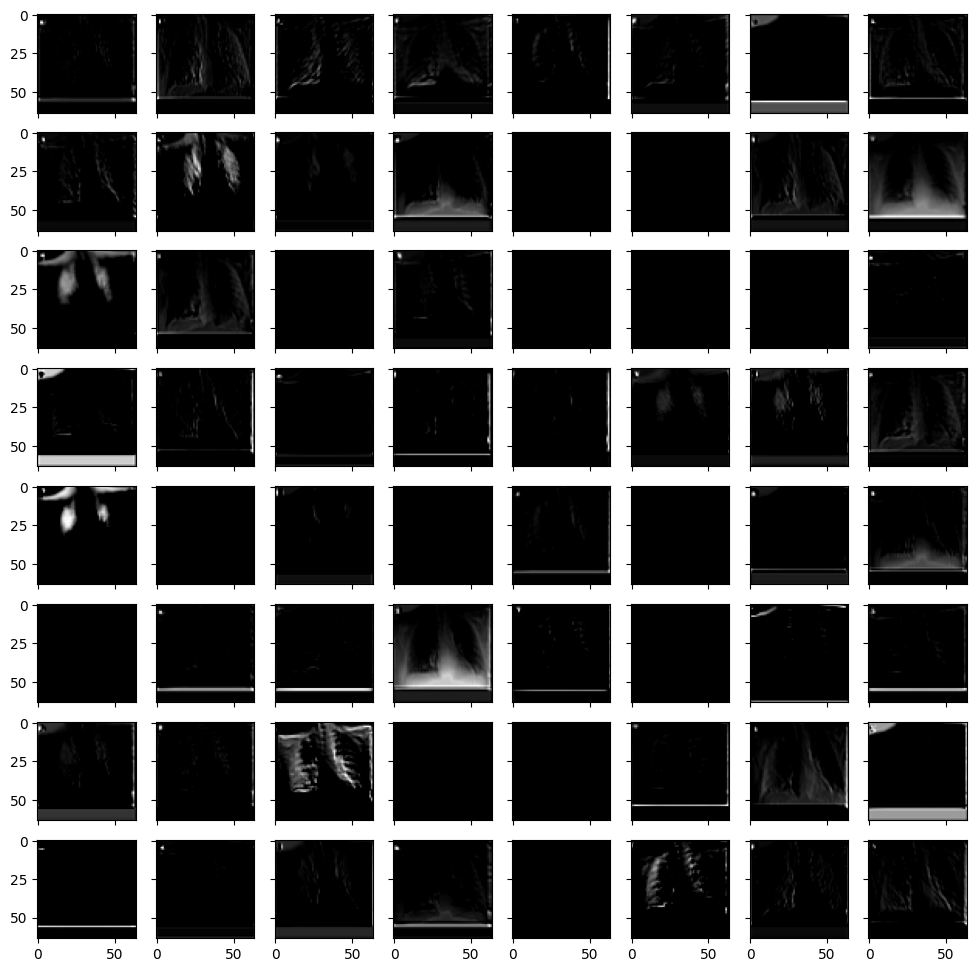

In [271]:
nrows = 8
ncols = 8
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(12, 12))
num_filer = min(nrows*ncols, activations.shape[-1])
for i in range(num_filer):
    image = activations[0, :, :, i]   
    ax.flatten()[i].imshow(image, cmap='gray')

plt.savefig(os.path.join(output_path, 'activation_conv_layer.png'), format='png')
plt.show()


In [62]:
def build_pattern(submodel, pattern_size, filter_index, epochs, step_size):
  # Initiate random noise
  input_img_data = np.random.random((1, pattern_size, pattern_size, 1))
  input_img_data = (input_img_data - 0.5) * 5 + 128.
  # input_img_data = 128. * np.ones((1, pattern_size, pattern_size, 1))

  # Cast random noise from np.float64 to tf.float32 Variable
  input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

  # Iterate gradient ascents
  for _ in range(epochs):
      with tf.GradientTape() as tape:
          outputs = submodel(input_img_data, training=False)
          loss_value = tf.reduce_mean(outputs[:, :, :, filter_index])
      grads = tape.gradient(loss_value, input_img_data)
      normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
      input_img_data.assign_add(normalized_grads * step_size)

  return input_img_data[0]

def build_pattern_list(submodel, pattern_size, nb_filter, epochs=100, step_size=1.):
  pattern_list = []
  for i in range(nb_filter):
    pattern_list.append(build_pattern(submodel, pattern_size, i, epochs, step_size))
  
  return pattern_list


In [ ]:
shared_encoder_4 = tf.keras.Sequential(name='shared_encoder_4')
for layer in shared_encoder.layers[:4]:
  shared_encoder_4.add(layer)


pattern_size = 11
inputs_pattern_size = layers.Input(shape=(pattern_size, pattern_size, 1))
augmented_input_pattern_size = augmentation(inputs_pattern_size)
shared_encoder_4_input_pattern_size = shared_encoder_4(augmented_input_pattern_size)

model_shared_encoder_input_pattern_size = keras.Model(inputs=inputs_pattern_size, outputs=shared_encoder_4_input_pattern_size)


In [63]:
epochs = 100
step_size = 1.

# Create a connection between the input and the target layer
submodel = model_shared_encoder_input_pattern_size

pattern_list = build_pattern_list(submodel, pattern_size, 64, epochs=epochs, step_size=step_size)


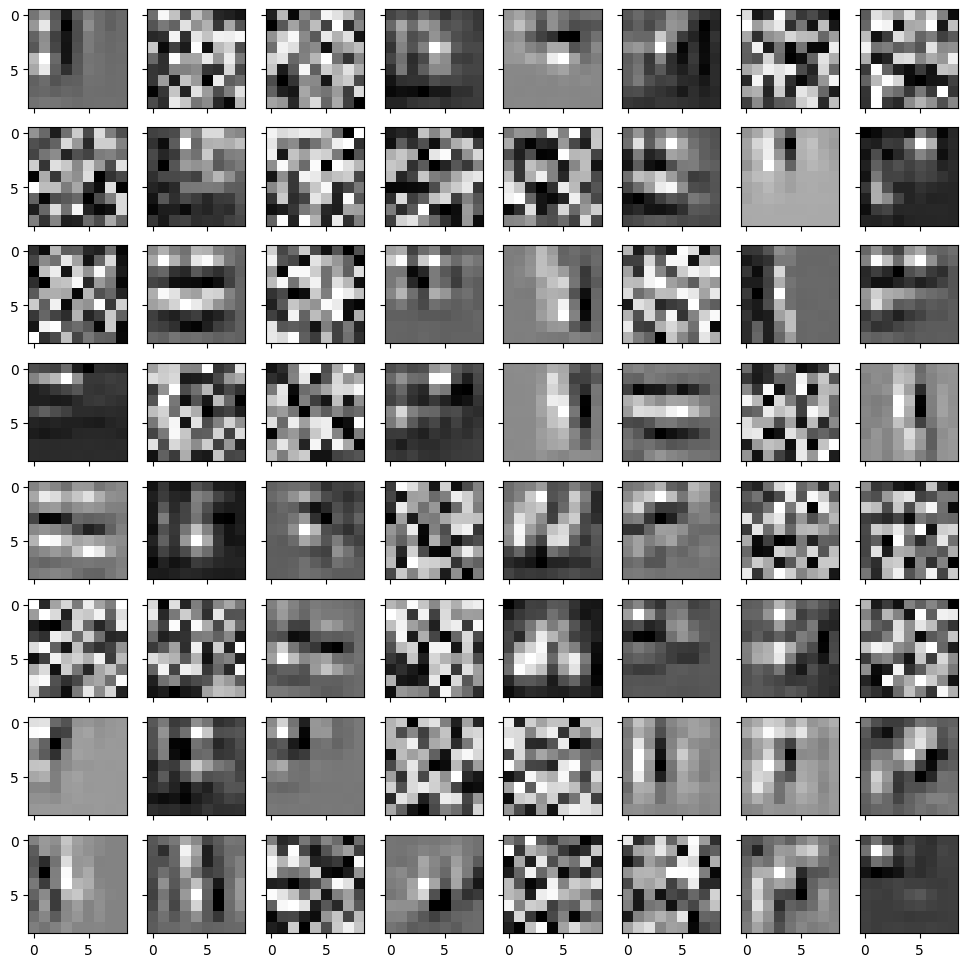

In [64]:
nrows = 8
ncols = 8
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(12, 12))
num_filer = min(nrows*ncols, len(pattern_list))
for i in range(num_filer):
    image = pattern_list[i]
    ax.flatten()[i].imshow(image, cmap='gray')

plt.savefig(os.path.join(output_path, 'pattern_conv_layer_4.png'), format='png')
plt.show()


In [90]:
# Create function to apply a grey patch on an image
def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = 127.5

    return patched_image

def occultation(img, patch_size=32, sub_samp_for_step=4, pred_index=None):
    sensitivity_map = np.zeros((img.shape[0], img.shape[1]))
    count_map = np.zeros((img.shape[0], img.shape[1]))

    # Iterate the patch over the image
    for top_left_x in range(0, img.shape[0], patch_size // sub_samp_for_step):
        for top_left_y in range(0, img.shape[1], patch_size // sub_samp_for_step):
            patched_image = apply_grey_patch(img, top_left_x, top_left_y, patch_size)
            predictions = model_study.predict(np.array([patched_image]))[0]
            if pred_index is None:
                pred_index = tf.argmax(predictions)
            confidence = predictions[pred_index]
            
            # Save confidence for this specific patched image in map
            sensitivity_map[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] \
            = (sensitivity_map[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] \
            * count_map[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] \
            + confidence) \
            / (count_map[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] + 1)

            count_map[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] += 1

    return sensitivity_map


In [ ]:
# Load image
img = keras.preprocessing.image.load_img(
    image_file_name,
    target_size=(image_size, image_size),
    grayscale=True)
img = keras.preprocessing.image.img_to_array(img)
img.shape

sensitivity_map = occultation(img, patch_size=32, sub_samp_for_step=4, pred_index=None)


In [73]:
# sensitivity_map.min()
heatmap = 1. - (sensitivity_map - sensitivity_map.min()) / (sensitivity_map.max() - sensitivity_map.min())
sens = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, sens, 0.5, 0)

# cv2_imshow(img)
cv2.imwrite(os.path.join(output_path, 'occultation.png'), output_image)


True

In [228]:
image_file_name = list_file_name[754]
image_file_name = list_file_name[1700]
image_file_name

'../data_equalize/Lung Segmentation Data/Train/COVID-19/images/sub-S10281_ses-E17796_run-1_bp-chest_vp-ap_cr.png'

In [91]:
def grad_cam(img, model, output_conv_layer, resize_shape=None, pred_index=None):
    grad_model = keras.Model(
        [model.input],
        [output_conv_layer, model.output])

    image_size = img.shape[0]

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img]), training=False)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    print(loss)
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads

    if resize_shape is None:
        weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    else:
        weights = tf.reduce_mean(guided_grads, axis=(0,))
    cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1).numpy()
    if resize_shape is not None:
        cam = cam.reshape(resize_shape)

    cam = cv2.resize(cam, (image_size, image_size))
    cam = np.maximum(cam, 0)
    # heatmap = (cam - cam.min()) / (cam.max() - cam.min())
    heatmap = cam / cam.max()

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

    return cam

def grad_cam_list(file_name_list, model, output_conv_layer, resize_shape=None, pred_index=None):
    cam_list = []

    for file_name in file_name_list:
        img = keras.preprocessing.image.load_img(
        file_name,
        target_size=(image_size, image_size),
        grayscale=True)
        img = keras.preprocessing.image.img_to_array(img)

        cam = grad_cam(img, model_transformer, output_conv_layer, resize_shape=resize_shape, pred_index=None)
        cam_list.append(cam)

    return cam_list


In [92]:
from random import sample

list_file_name = list_file_name_covid
title = 'Grad_CAM_covid'

nrows = 8
ncols = 8
num_img = nrows * ncols

samples = list_file_name
if (len(samples) >= num_img):
  samples = samples.sample(samples, num_img)

# output_conv_layer = model_transformer.get_layer(encoder_name).get_output_at(0)
# resize_shape = None
output_conv_layer = model_transformer.get_layer('layer_normalization_8').get_output_at(0)
resize_shape = (8, 8)

cam_list = grad_cam_list(samples, model, output_conv_layer, resize_shape=resize_shape, pred_index=None)


['../data_equalize/Lung Segmentation Data/Test/Normal/images/Normal (8958).png',
 '../data_equalize/Lung Segmentation Data/Test/Normal/images/Normal (8237).png',
 '../data_equalize/Lung Segmentation Data/Test/Normal/images/Normal (372).png',
 '../data_equalize/Lung Segmentation Data/Test/Normal/images/Normal (8667).png',
 '../data_equalize/Lung Segmentation Data/Test/Normal/images/Normal (9076).png',
 '../data_equalize/Lung Segmentation Data/Test/Normal/images/Normal (9563).png',
 '../data_equalize/Lung Segmentation Data/Test/Normal/images/Normal (9099).png',
 '../data_equalize/Lung Segmentation Data/Test/Normal/images/Normal (9133).png',
 '../data_equalize/Lung Segmentation Data/Test/Normal/images/Normal (8372).png',
 '../data_equalize/Lung Segmentation Data/Test/Normal/images/Normal (237).png',
 '../data_equalize/Lung Segmentation Data/Test/Normal/images/Normal (8688).png',
 '../data_equalize/Lung Segmentation Data/Test/Normal/images/Normal (8722).png',
 '../data_equalize/Lung Segmen

In [ ]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle(title)
ax = fig.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True)
for i, (image, file_name) in enumerate(zip(cam_list, samples)):
  axe = ax[k]

  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  im_pil = Image.fromarray(img)

  axe.imshow(im_pil)
  f_name = os.path.basename(file_name)[:10]
  # print(f_name)
  axe.set_title(f_name)

plt.savefig(os.path.join(output_path , title + '.png'), format='png')
plt.show()
plt.close(fig)


In [ ]:
# Load image
print(image_file_name)
img = keras.preprocessing.image.load_img(
    image_file_name,
    target_size=(image_size, image_size),
    grayscale=True)
img = keras.preprocessing.image.img_to_array(img)

# output_conv_layer = model_transformer.get_layer(encoder_name).get_output_at(0)
# resize_shape = None
output_conv_layer = model_transformer.get_layer('layer_normalization_8').get_output_at(0)
resize_shape = (8, 8)

cam = grad_cam(img, model_transformer, output_conv_layer, resize_shape=resize_shape, pred_index=None)


In [89]:
output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 0.5, 0)

# cv2_imshow(img)
cv2.imwrite(os.path.join(output_path, 'grad_cam.png'), output_image)


True